<p align="center">
<img align="center" src="https://image.freepik.com/free-vector/write-missing-number-worksheet-education_71599-3881.jpg">
</p>

[Image source](https://www.freepik.com/premium-vector/write-missing-number-worksheet-education_19499165.htm#page=1)


<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Sequence prediction.</h1>


## Please use nbviewer to read this notebook to use all it's features:
https://nbviewer.org/github/sersonSerson/Projects/blob/master/NaturalLanguage/SequencePrediction/SequencePrediction.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [Introduction.](#Step1)
## 2. [Create data.](#Step2)
## 3. [Preprocess data.](#Step3)
## 4. [Create models.](#Step4)
## 4. [Train model.](#Step5)
## 5. [Predict and score.](#Step6)
## 6. [Conclusion.](#Step7)

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Introduction. </span>

## Goal: encoder-decoder architecture training and understanding.

## 1. Problem.
Create a Neural Network that will make sequence-to-sequence predictions.

## 2. Data.
### The data will be prepared following the logic:
1. Create simple 6 number sequence for inputs:
e.g. [29, 14, 9, 28, 34, 25]
2. Create 3 number sequences for outputs that are 3 last numbers from input
sequence in reversed order:
e.g. [9, 14, 29]
3. Create 3 number sequences for one timestep shifted outputs:
e.g. [0, 9, 14]

These sequences will be encoded in one-hot encoding manner.

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Create data. </span>

In [14]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input

In [15]:
def create_data(n_samples, n_input, n_output, n_dict):

    X1, X2, y = list(), list(), list()
    for i in range(n_samples):
        sample = []
        for j in range(n_input):
            sample.append(random.randint(1, n_dict - 1))
        X1.append(sample)
        target_sample = sample[:n_output]
        target_sample.reverse()
        X2.append([0] + target_sample[:-1])
        y.append(target_sample)
    X1 = to_categorical(X1, num_classes=n_dict)
    X2 = to_categorical(X2, num_classes=n_dict)
    y = to_categorical(y, num_classes=n_dict)
    return X1, X2, y

n_input = 6
n_output = 3
n_dict = 50 + 1
n_samples = 1
X1, X2, y = create_data(n_samples, n_input, n_output, n_dict)
X1.shape

(1, 6, 51)

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Preprocess data. </span>

## Create function for decoding from one-hot encoded style into number

In [16]:
def decode_seq(data):
    return np.argmax(data, axis=-1)

decode_seq(X1)

array([[19, 30, 22,  2,  5,  9]], dtype=int64)

In [17]:
decode_seq(X2)

array([[ 0, 22, 30]], dtype=int64)

In [18]:
decode_seq(y)

array([[22, 30, 19]], dtype=int64)

<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Create models. </span>

1. Train model - used while training to fit weights in LSTM and Dense layers.
2. Encoder model - model that creates states during the prediction phase.
3. Decoder model - model that generates sequences during the prediction phase.

## Training model

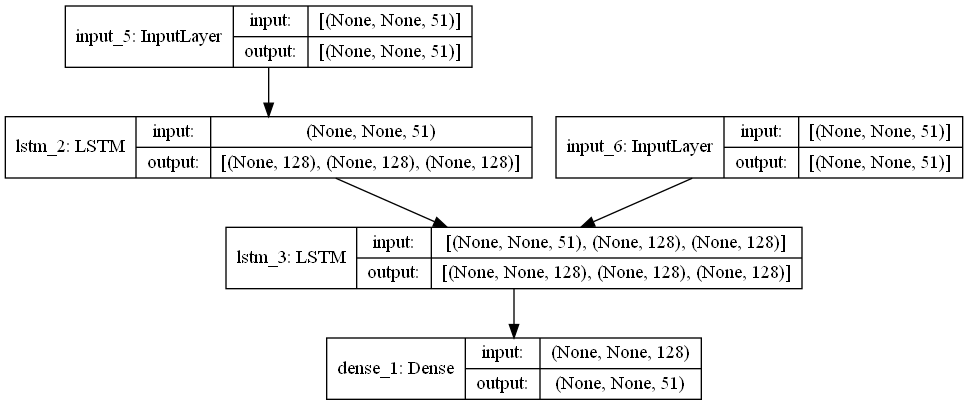

In [19]:
lstm_units = 128
# Input layer for X
encoder_input = Input(shape=(None, n_dict))
# LSTM with  will return hidden state for the last time step
# (shape (2 * 1 * 128)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_output, encoder_h, encoder_c = encoder_lstm(encoder_input)
encoder_states = [encoder_h, encoder_c]

decoder_input = Input(shape=(None, n_dict))
decoder_lstm = LSTM(lstm_units, return_state=True, return_sequences=True)
decoder_output, decoder_h, decoder_c = \
    decoder_lstm(decoder_input, encoder_states)
decoder_dense = Dense(n_dict, activation='softmax')
decoder_output = decoder_dense(decoder_output)
train_model = Model([encoder_input, decoder_input], decoder_output)
plot_model(train_model, show_shapes=True)

## Encoder model

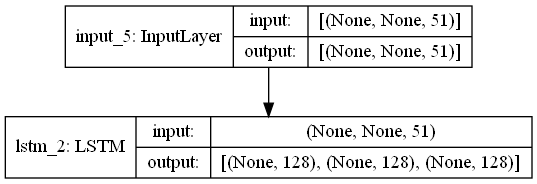

In [20]:
encoder_model = Model(encoder_input, encoder_states)
plot_model(encoder_model, show_shapes=True)

## Decoder model

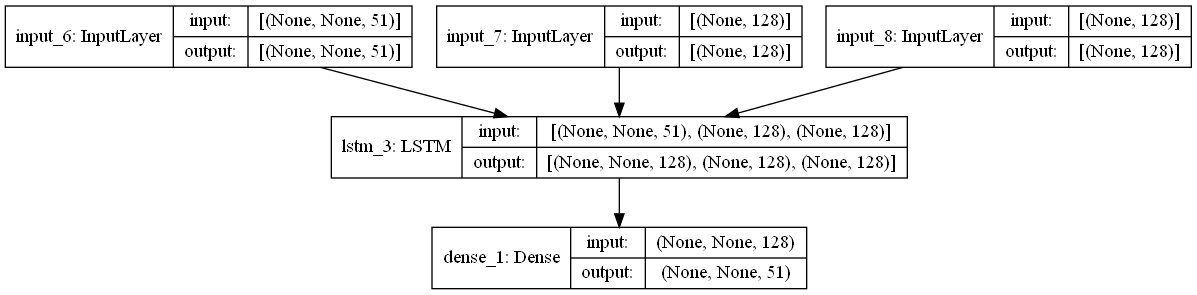

In [21]:
decoder_input_h = Input(shape=(lstm_units, ))
decoder_input_c = Input(shape=(lstm_units, ))
decoder_input_states = [decoder_input_h, decoder_input_c]
decoder_output, decoder_state_h, decoder_state_c = \
    decoder_lstm(decoder_input, initial_state=decoder_input_states)
decoder_states = [decoder_state_h, decoder_state_c]
decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_input_states, [decoder_output]
                      + decoder_states)
plot_model(decoder_model, show_shapes=True)

## Generate lots of sequences for training (100 000)

In [22]:
n_input = 6
n_output = 3
n_dict = 50 + 1
n_samples = 1
X1, X2, y = create_data(100000, n_input, n_output, n_dict)
X1.shape, X2.shape, y.shape

((100000, 6, 51), (100000, 3, 51), (100000, 3, 51))

<div id="Step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5. Train model. </span>

## Compile and fit training model

In [23]:
train_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics=['accuracy'])
train_model.fit([X1, X2], y, epochs=2, verbose=2)

Epoch 1/2
3125/3125 - 21s - loss: 0.6432 - accuracy: 0.7954
Epoch 2/2
3125/3125 - 18s - loss: 0.0111 - accuracy: 0.9992


<div id="Step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6. Predict and score. </span>

## Generate test data

In [42]:
X1_test, X2_test, y_test = create_data(1, n_input, n_output, n_dict)
print(f'X1: {decode_seq(X1_test[0])} X2: {decode_seq(X2_test[0])} '
      f'y: {decode_seq(y_test[0])}')

X1: [19  2 33 25 38 20] X2: [ 0 33  2] y: [33  2 19]


## Make a prediction and check it

In [43]:
def predict_sequence(X1):
    enc_state_h, enc_state_c = encoder_model.predict(X1)
    h_prev = np.array([0.0 for i in range(n_dict)]).reshape(1, 1, n_dict)
    pred = []
    for i in range(n_output):
        y_hat, enc_state_h, enc_state_c = \
            decoder_model.predict([h_prev, enc_state_h, enc_state_c])
        pred.append(decode_seq(y_hat)[0][0])
        h_prev = y_hat
    return np.array(pred)
pred = predict_sequence(X1_test)
print(f'y true: {decode_seq(y_test[0])} y pred: {pred}')

y true: [33  2 19] y pred: [33  2 19]


## Score model

In [57]:
n_samples = 100
accuracy = 0
X1_test, X2_test, y_test = create_data(n_samples, n_input, n_output, n_dict)
for i in range(n_samples):
    y_pred = predict_sequence(X1_test[i].reshape(1, 6, 51))
    if np.array_equal(decode_seq(y_test[i]), y_pred):
        accuracy += 1
print(f'Accuracy score: {accuracy}%')

Accuracy score: 100%


<div id="Step7">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 7. Conclusion. </span>

## After completion of this small project:
* Got better understanding of Encoder-Decoder structures.